In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool
import json
from source import *
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

import scienceplots

plt.style.use(['science','ieee', 'grid'])

In [2]:
dataset = ds.dataset(list(Path(f"new_sig/").glob("*.parquet")), format="parquet")

In [306]:
scanner = dataset.scanner(batch_size=100_000)
for batch in scanner.to_batches():
    table = pa.Table.from_batches([batch])
    display(table.to_pandas().columns)
    break
del scanner

Index(['__experiment__', '__run__', '__event__', '__production__', 'pcm',
       'ecm', 'missedE', 'recM2_Ups', 'pmiss', 'cmpmiss', 'thetamiss',
       'cmthetamiss', 'cmfox', 'fox', 'asymmetry', 'p0', 'theta_Bs', 'M0',
       'recM2_Bs', 'idec0', 'idec1', 'is0', 'N_KL', 'Miss_id_0', 'Miss_id_1',
       'Bs_lik', 'N_KS', 'theta_tau_0', 'p_tau_0', 'theta_tau_1', 'p_tau_1',
       'tau_d_0_0', 'tau_d_1_0', 'tau_last_z_0', 'tau_last_r_0',
       'tau_last_z_1', 'tau_last_r_1', 'Istau0', 'Istau1', 'Chi_sq_0',
       'Chi_sq_1', 'dr0', 'dr1', 'totalEnergyMC', 'E_gamma_in_ROE',
       'correct_nu_0', 'correct_nu_1', 'correct_gamma_0', 'correct_gamma_1',
       'lost_0', 'lost_1', 'PID_self_vs_0_tau0', 'PID_self_vs_1_tau0',
       'PID_self_vs_2_tau0', 'PID_self_vs_4_tau0', 'PID_self_vs_0_tau1',
       'PID_self_vs_1_tau1', 'PID_self_vs_2_tau1', 'PID_self_vs_4_tau1'],
      dtype='object')

In [307]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]
mask = (pc.field("E_gamma_in_ROE") < 1.2) & (pc.field("Bs_lik") > 0.0012)
mask_is1 = pc.field("correct_nu_0") & pc.field("correct_nu_1") & pc.field("correct_gamma_0") & pc.field("correct_gamma_1") & pc.field("lost_0") & pc.field("lost_1") & pc.field("Miss_id_0") & pc.field("Miss_id_1")
mask_is0 = pc.field("is0") == 1
mask_lep = ((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1))


<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_14560\1520325049.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [308]:
decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\matve\AppData\Local\Temp\ipykernel_14560\1033810642.py:1: SyntaxWarning: invalid escape sequence '\m'
  decay_mod_tau = ["$e^+ \\nu_e \\bar \\nu_\\tau$", "$\mu^+ \\nu_\\mu \\bar \\nu_\\tau$", "$\\pi^+ \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\pi^0) \\bar \\nu_\\tau$", "$\\pi^+ \\pi^+ \\pi^- \\bar \\nu_\\tau$", "$\\rho^+ (\\pi^+ \\gamma) \\bar \\nu_\\tau$"]


In [309]:
import json
with open("columns_and_fom.json", "r") as f:
    data_to_save = json.load(f)
columns = data_to_save["columns"]
FoM = data_to_save["FoM"]

In [310]:
data = get_values(dataset, columns + ['E_gamma_in_ROE', 'M0'], filter_mask=(mask & mask_lep & (pc.field("is0") == 1) & mask_is1))

Total data size: 5.09 MB


In [311]:
wbin = 0.05
a = 0
b = 1.2
bins = np.linspace(a, b, int((b-a)/wbin))

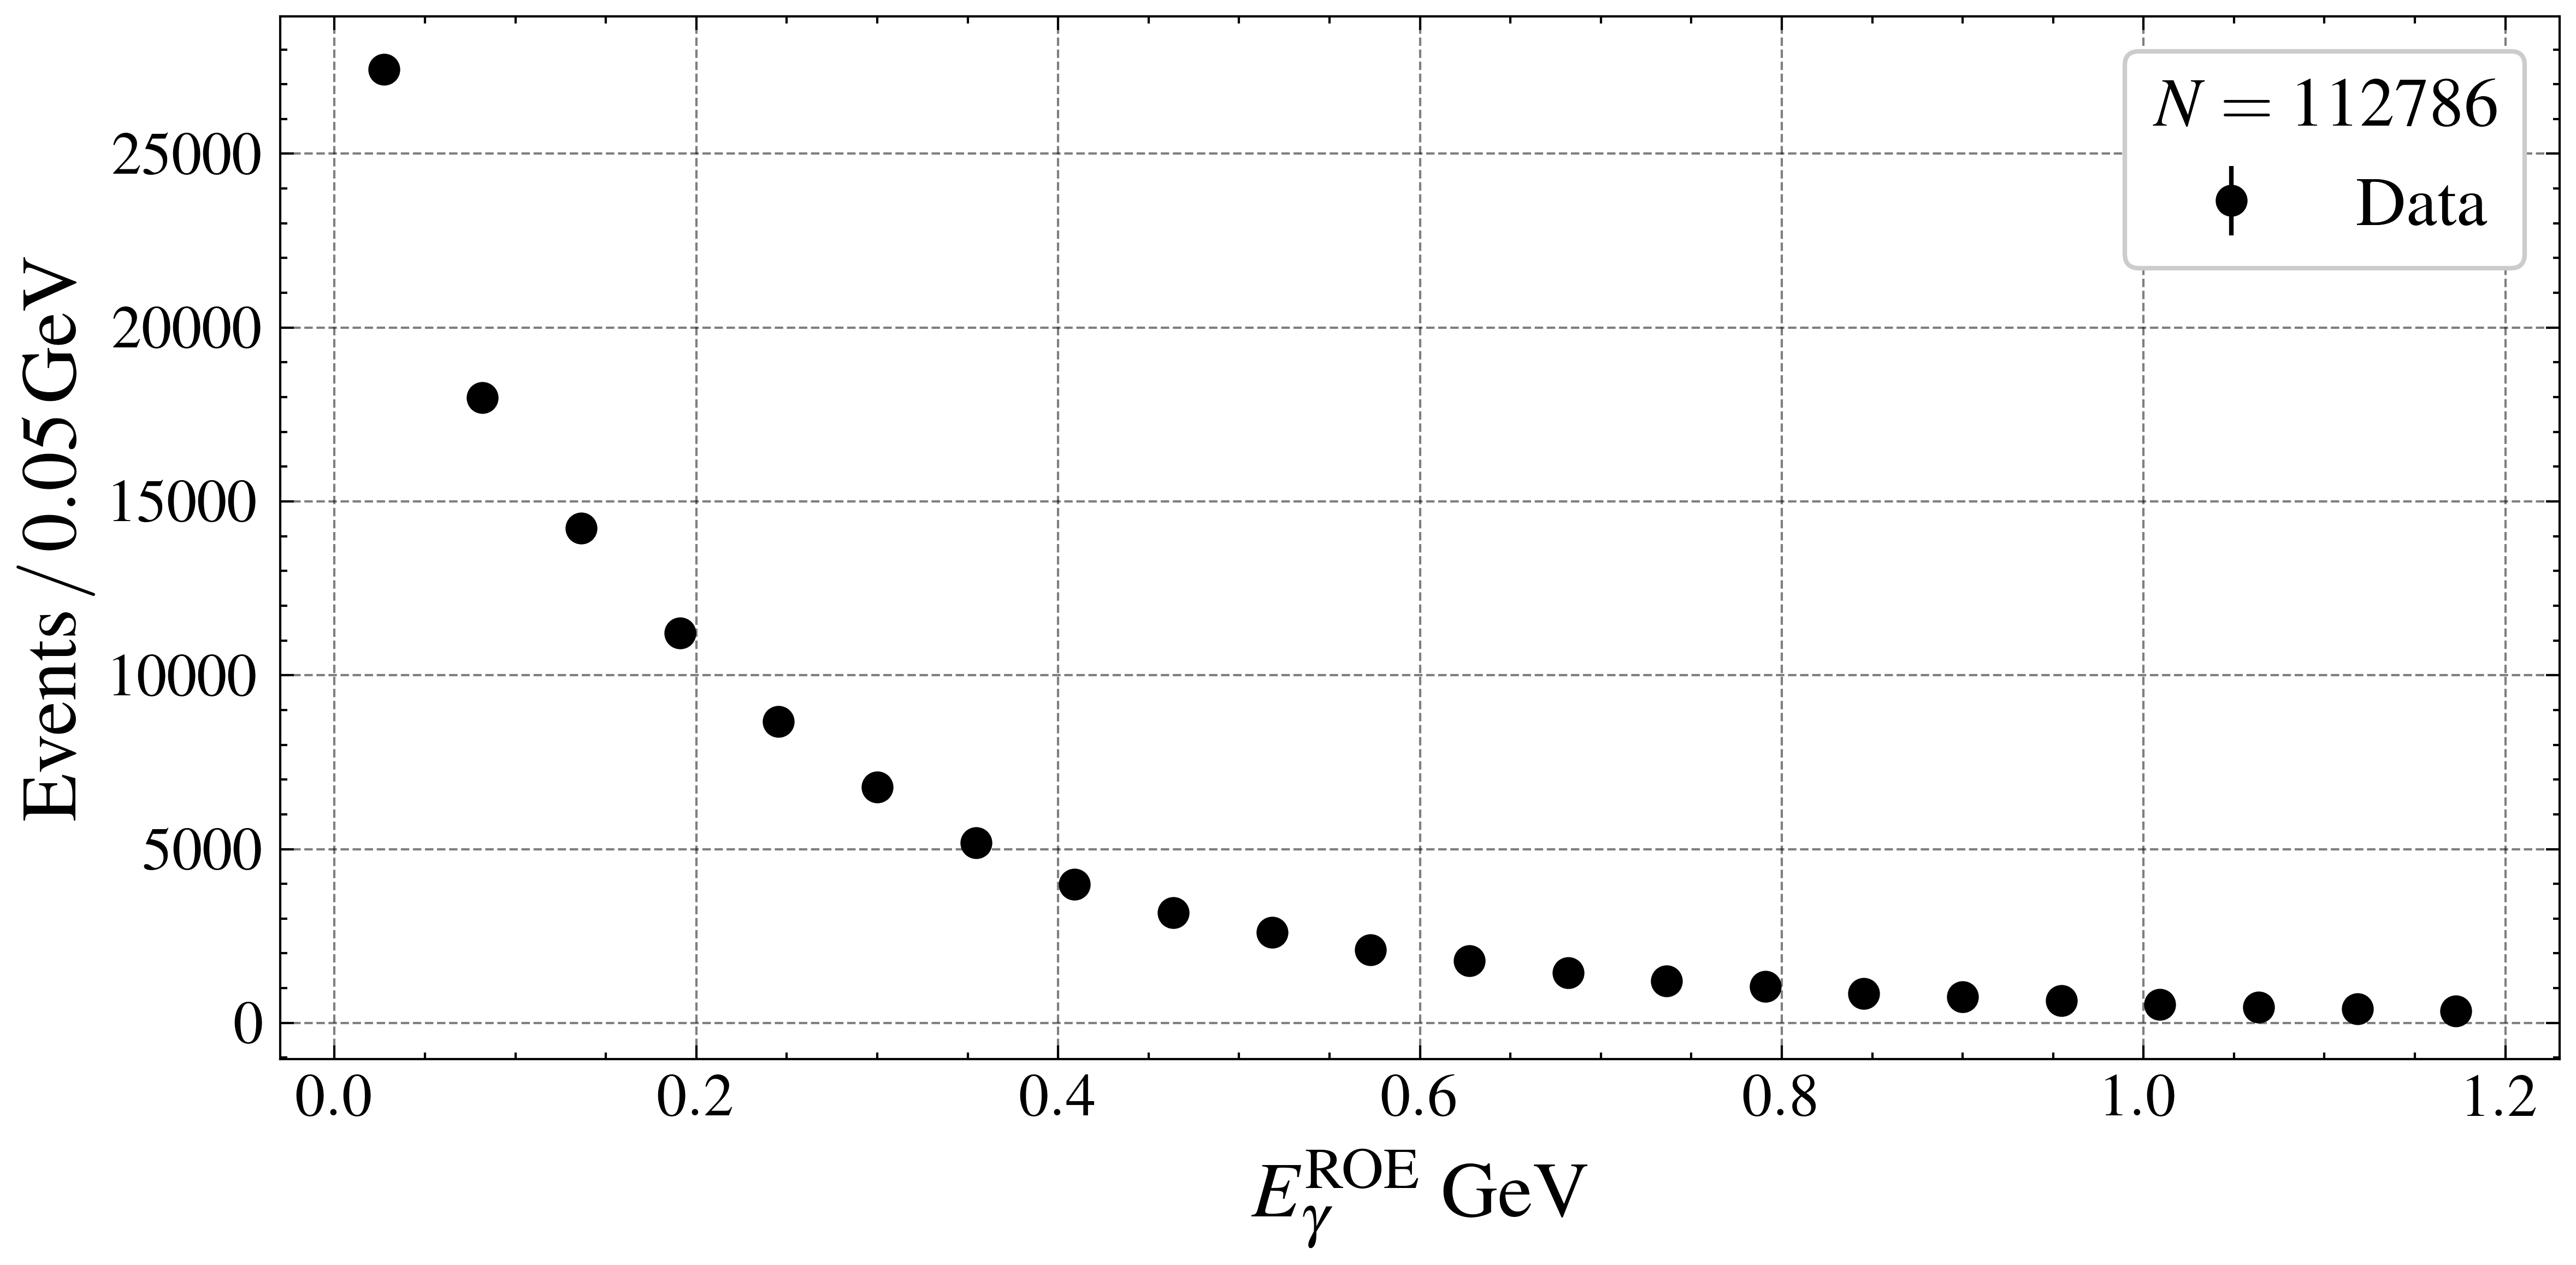

In [312]:
bin_centers, counts, N = compute_histogram(dataset, bins, "E_gamma_in_ROE", filter_mask= mask & mask_lep & (pc.field("is0") == 1) & mask_is1)


fig, ax = plt.subplots(1, figsize=(12/1.5, 6/1.5))

ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label="Data")
ax.set_ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}\\,\\mathrm{{GeV}}$')
ax.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax.set_title("")
ax.legend(title=f"$N = {N}$")

plt.tight_layout()
plt.show()

In [299]:
@njit(fastmath=True)
def exp_dis(x, lam, a=0, b=0):
    if a == b:
        normalization_factor = 1
    else:
        normalization_factor = lam / (np.exp(lam * (b)) - np.exp(lam * (a)))
    return normalization_factor * np.exp(lam * x)

In [300]:
BS0 = 5.366691

In [320]:
wbin_x, a_x, b_x = 0.05, 0, 1.2
wbin_y, a_y, b_y = 0.005, BS0-0.05, BS0+0.05

bins_x = np.linspace(a_x, b_x, int((b_x - a_x) // wbin_x))
bins_y = np.linspace(a_y, b_y, int((b_y - a_y) // wbin_y))

In [321]:
from pyarrow import dataset as ds
from pyarrow import compute as pc
from pyarrow import Table
from typing import Union, List, Optional, Tuple
import numpy as np

def compute_nd_histogram(
    dataset: ds.Dataset,
    bins: Union[np.ndarray, List[np.ndarray]],
    targets: Union[str, List[str]],
    fun=lambda x: x,
    filter_mask: Optional[pc.Expression] = None,
    norm: bool = False,
    nanto: float = np.nan
) -> Tuple[List[np.ndarray], np.ndarray, int]:
    """
    Строит N-мерную гистограмму по колонкам `targets`.

    :param dataset: pyarrow dataset
    :param bins: либо общее количество бинов (int), либо список массивов биннинга по каждой оси
    :param targets: список колонок (или одна колонка)
    :param fun: функция преобразования значений до гистограммы
    :param filter_mask: pyarrow фильтр
    :param norm: нормировать ли результат
    :param nanto: чем заменить NaN
    :return: (список центров биннов по осям, массив счётчиков, число событий)
    """
    if isinstance(targets, str):
        targets = [targets]

    if isinstance(bins, np.ndarray):
        bins = [bins] * len(targets)

    bin_centers = [0.5 * (b[:-1] + b[1:]) for b in bins]
    hist_counts = np.zeros_like(np.meshgrid(*bin_centers, indexing='ij')[0])
    scanner = dataset.scanner(batch_size=100_000, filter=filter_mask)

    for batch in scanner.to_batches():
        table = Table.from_batches([batch])
        df = table.select(targets).to_pandas()
        df = df.fillna(nanto)
        values = df.values

        counts, _ = np.histogramdd(values, bins=bins)
        hist_counts += counts

    total_events = int(np.sum(hist_counts))

    # Вычисляем центры биннов по каждой оси

    if norm and total_events > 0:
        hist_counts /= total_events
    bin_centers = np.meshgrid(*bin_centers, indexing='ij')
    return bin_centers, hist_counts, total_events


In [322]:
bin_centers, counts, N = compute_nd_histogram(dataset, [bins_x, bins_y], ["E_gamma_in_ROE", "M0"], filter_mask = mask & mask_lep & (pc.field("is0") == 1) & mask_is1)

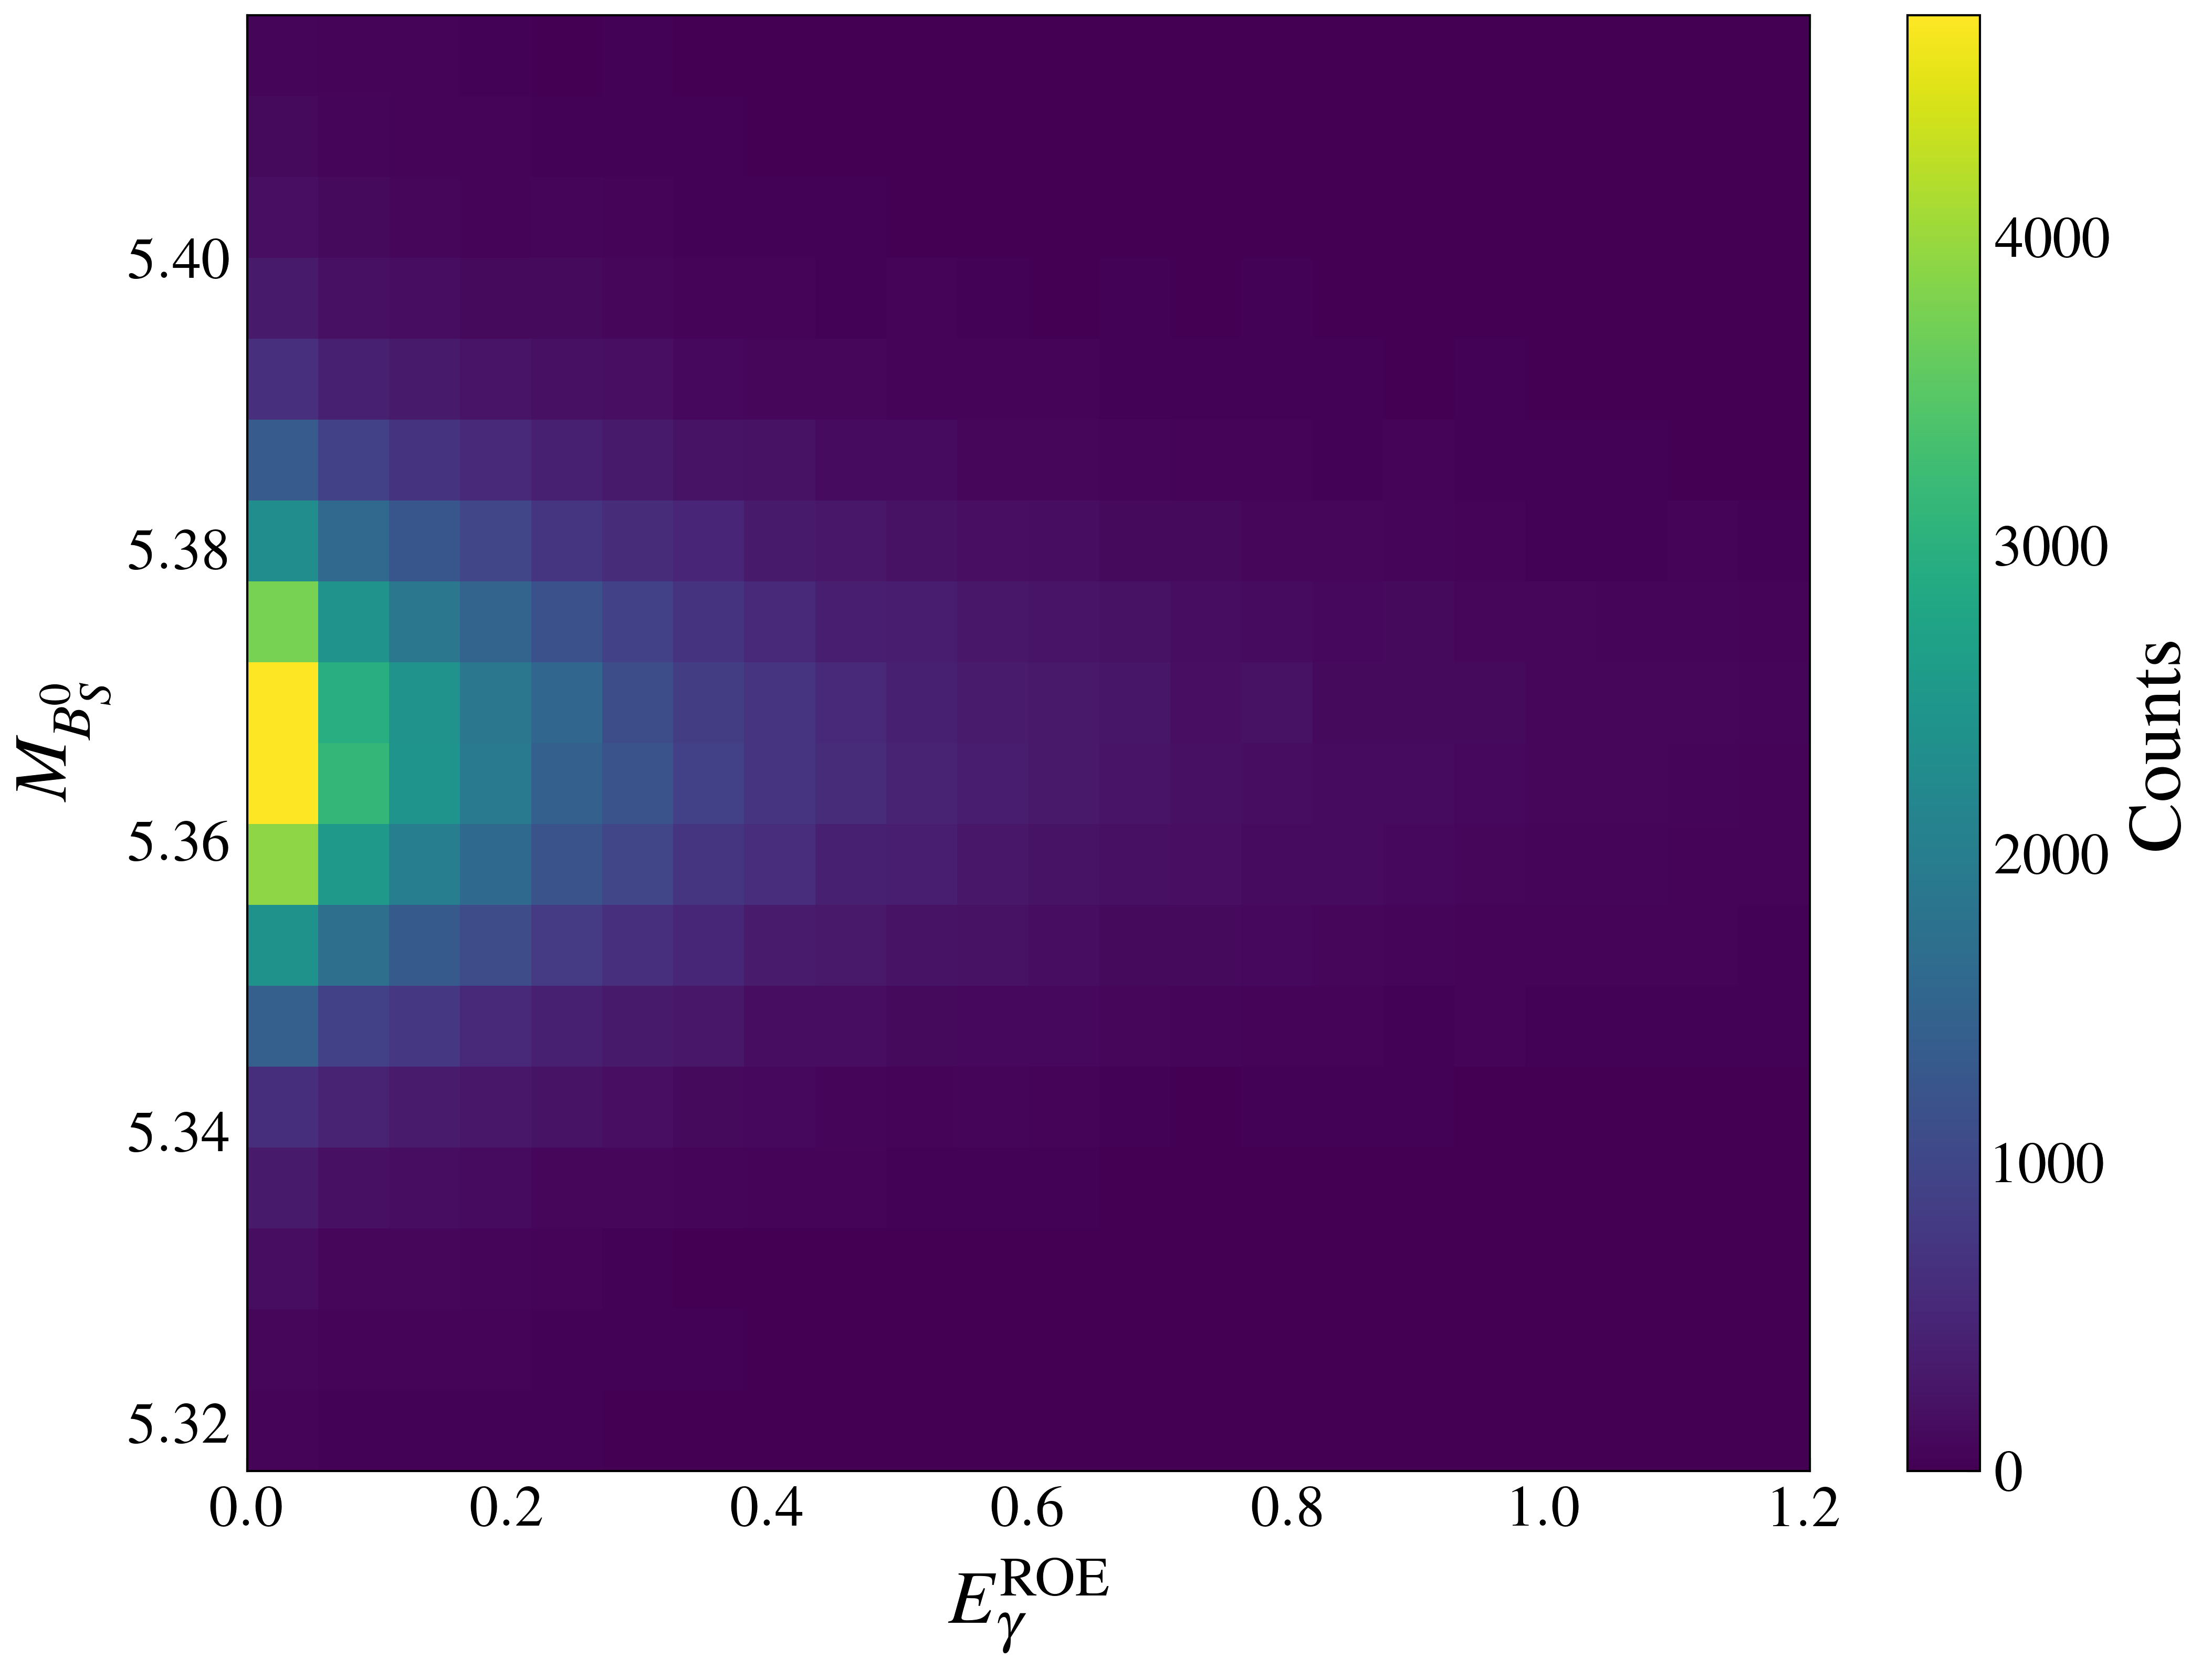

In [323]:

plt.figure(figsize=(8, 6))
pmesh = plt.pcolormesh(*bin_centers, counts)
plt.xlabel(r"$E_\gamma^{\mathrm{ROE}}$")
plt.ylabel(r"$M_{B_S^0}$")
plt.colorbar(pmesh, label="Counts")
plt.show()

In [324]:
def f_E_g_lep_gamma(x, lam, k, theta):
    from scipy.special import gamma
    x = x*lam
    base = (1 / (gamma(k) * theta**k)) * x**(k - 1) * np.exp(-x / theta)
    return base

In [426]:
def f_sig(x, *, lam, k, theta, mu, sig1, sig2, A):
    return f_E_g_lep_gamma(x[0], lam, k, theta)*(gaussian(x[1], mu, sig1)*A + gaussian(x[1], mu, sig2)*(1 - A))

In [501]:
args = {
    "k": 0.78016,
    'theta': 1.1835581549978382, 
    'lam': 4.022076506227866,
    "mu": BS0,
    "sig1": 0.013532784081646893,
    "sig2": 0.01,
    "A": 1.0
}

In [596]:
def max_bin_lik(f, bin_centers, counts, args0, bounds=dict(), err_need = False):
    from scipy.special import factorial

    def puasson(x, n):
        return np.exp(-x)*np.power(x, n)*np.power(factorial(n), -1)

    normalization = np.max(counts)//10
    counts = counts/normalization
    norm = np.sum(counts)
    args0["norm"] = norm

    pdf = lambda x, **args: f(x, **{k: v for k, v in args.items() if k != "norm"})/np.sum(f(x, **{k: v for k, v in args.items() if k != "norm"})) * args["norm"]

    bounds["norm"] = (0, norm*10)
    def df(*arg_values):
        current_args = {k: v for k, v in zip(args0.keys(), arg_values)}
        expected = pdf(bin_centers, **current_args)
        pu = puasson(expected, counts)
        pu = np.where(pu > 1e-12, pu, 1e-12)  # защита от log(0)
        return -2 * np.sum(np.log(pu))    
    minuit = Minuit(df, *[args0[__key] for __key in args0.keys()], name=args0.keys())
    for k, bnd in bounds.items():
        minuit.limits[k] = bnd
    minuit.migrad()
    print(df(*[args0[__key] for __key in args0.keys()]))
    print(df(*[minuit.values.to_dict()[__key] for __key in minuit.values.to_dict().keys()]))
    rez = minuit.values.to_dict()
    print(rez)
    rez["norm"] = rez["norm"]* normalization
    if err_need:
        return rez, pdf, norm, minuit.errors
    return rez, pdf

In [597]:
rez, pdf = max_bin_lik(f_sig, bin_centers, counts, args)

376.3246048051257
371.38640950082635
{'k': 0.7934878370932088, 'theta': 1.1748051685560617, 'lam': 3.9957946177153327, 'mu': 5.366471278418168, 'sig1': 0.02319771118187595, 'sig2': 0.011444906057231318, 'A': 0.16877834509072054, 'norm': 236.66455171358865}


In [599]:
with open("sig_fit.json", "w") as f:
    json.dump(rez, f, indent=4)

In [600]:
plt_s = (12/1.7, 6/1.7)
pull_s = (12/6, 6/6)

In [601]:
bin_centers[1][0,:]

array([5.31946878, 5.32502433, 5.33057989, 5.33613544, 5.341691  ,
       5.34724656, 5.35280211, 5.35835767, 5.36391322, 5.36946878,
       5.37502433, 5.38057989, 5.38613544, 5.391691  , 5.39724656,
       5.40280211, 5.40835767, 5.41391322])

In [602]:
mask = counts == 0
chi = (pdf(bin_centers, **rez)-counts)/np.sqrt(counts)
chi[mask] = 0
print(np.mean(chi))

fit_proj_x = np.sum(pdf(bin_centers, **rez), axis=1)
counts_proj_x = np.sum(counts, axis=1)

mask = counts_proj_x == 0
chi = (fit_proj_x - counts_proj_x) / np.sqrt(np.where(counts_proj_x == 0, 1, counts_proj_x))
chi[mask] = 0

print(np.mean(chi))


0.061698855089700994
-0.1717469779726974


C:\Users\matve\AppData\Local\Temp\ipykernel_14560\113968960.py:2: RuntimeWarning: divide by zero encountered in divide
  chi = (pdf(bin_centers, **rez)-counts)/np.sqrt(counts)


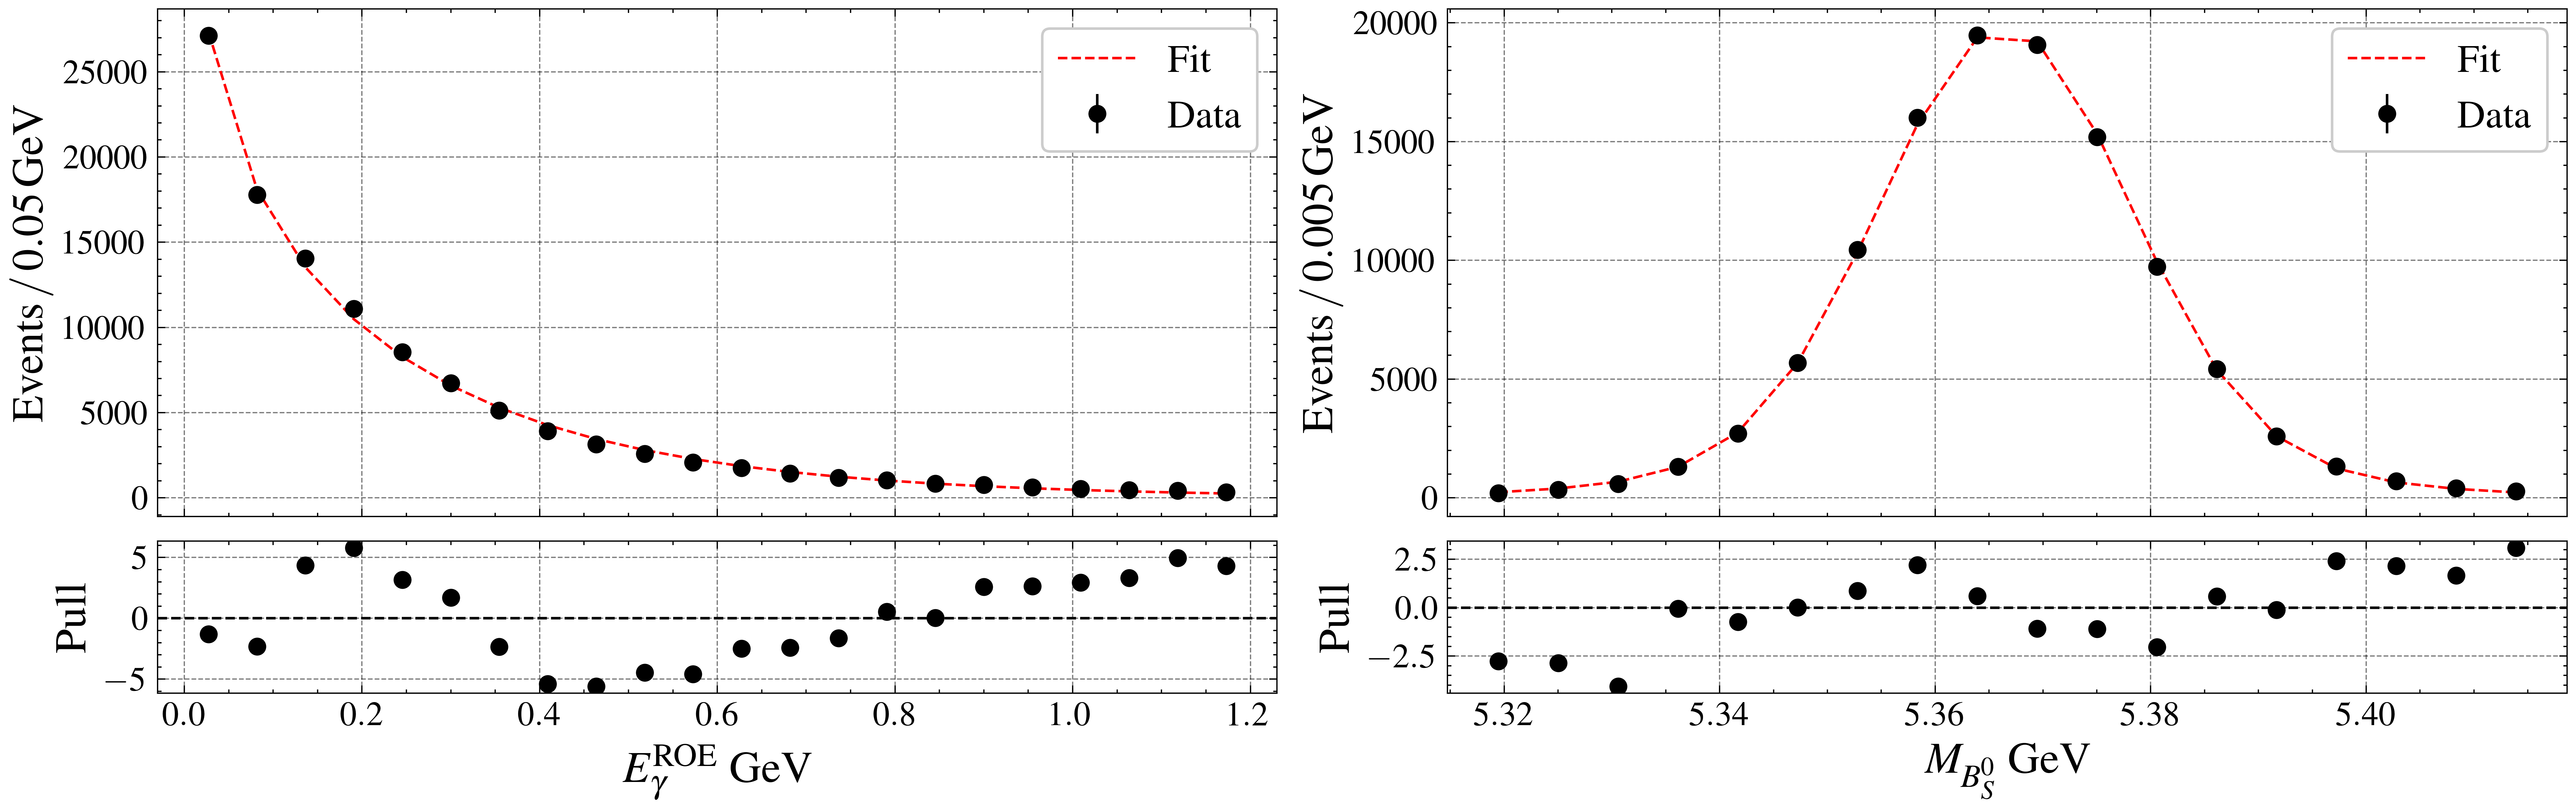

In [605]:
fig, axs = plt.subplots(2, 2, figsize=(2*plt_s[0], plt_s[1]+pull_s[1]), 
                        gridspec_kw={'height_ratios': [1, 0.3]}, sharex='col')

counts_proj_x = np.sum(counts, axis=1)
bin_centers_x = bin_centers[0][:, 0]
fit_proj_x = np.sum(pdf(bin_centers, **rez), axis=1)

ax = axs[0, 0]
ax.errorbar(bin_centers_x, counts_proj_x, yerr=np.sqrt(counts_proj_x), fmt='o', label="Data")
ax.plot(bin_centers_x, fit_proj_x, label="Fit")
ax.set_ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_x}\,\mathrm{{GeV}}$')
ax.legend()

ax_resid = axs[1, 0]
pulls_x = (counts_proj_x - fit_proj_x) / np.sqrt(np.where(counts_proj_x==0, 1, counts_proj_x))
ax_resid.plot(bin_centers_x, pulls_x, 'o')
ax_resid.axhline(0, color='black', lw=1, ls='--')
ax_resid.set_xlabel(r'$E_{\gamma}^\mathrm{ROE} \ \mathrm{GeV}$')
ax_resid.set_ylabel(r'$\mathrm{Pull}$')

counts_proj_y = np.sum(counts, axis=0)
bin_centers_y = bin_centers[1][0, :]
fit_proj_y = np.sum(pdf(bin_centers, **rez), axis=0)

ax = axs[0, 1]
ax.errorbar(bin_centers_y, counts_proj_y, yerr=np.sqrt(counts_proj_y), fmt='o', label="Data")
ax.plot(bin_centers_y, fit_proj_y, label="Fit")
ax.set_ylabel(fr'$\mathrm{{Events}}\,/\,{wbin_y}\,\mathrm{{GeV}}$')
ax.legend()

ax_resid = axs[1, 1]
pulls_y = (counts_proj_y - fit_proj_y) / np.sqrt(np.where(counts_proj_y==0, 1, counts_proj_y))
ax_resid.plot(bin_centers_y, pulls_y, 'o')
ax_resid.axhline(0, color='black', lw=1, ls='--')
ax_resid.set_xlabel(r'$M_{B_S^0} \ \mathrm{GeV}$')
ax_resid.set_ylabel(r'$\mathrm{Pull}$')

plt.tight_layout()
plt.show()
